In [41]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from keras.preprocessing.image import img_to_array, load_img

from keras import backend as K

from keras.utils import to_categorical
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50

from keras.layers import *
from keras.models import Model, load_model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.layers import Reshape

import threading
import pickle
import cv2
from cv2 import VideoWriter, VideoWriter_fourcc
import skvideo.io
import imageio

import io
import base64
from IPython.display import HTML

%matplotlib inline

In [2]:
train_path = "dashcam/frames/training/positive"
test_path = "dashcam/frames/testing/positive"

frames_path = {}

train_data = []
test_data = []

In [3]:
def make_sequences(frames, mode):
    frames = sorted(frames)
    sequences = []

    for i in range(0, 100, 25):
        sequence = frames[i:(i + 25)]
        if i < 75:
            label = np.zeros(25)
        else:
            label = np.concatenate((np.zeros(15), np.ones(10)), axis = 0)
        item = sequence, label
        if(mode == "train"):
            train_data.append(item)
        elif(mode == "test"):
            test_data.append(item)

In [4]:
for category in ["train", "test"]:
    data_path = train_path if category == "train" else test_path
    
    for video in os.listdir(data_path):
        frames = []
        for frame in os.listdir(data_path + "/" + video):
            frames.append(video + "_" + frame)
            frames_path[video + "_" + frame] = data_path + "/" + video
        if(len(frames) == 100):
            make_sequences(frames, category)

In [5]:
def image_to_tensor(filename):
  
    tokens = filename.split("_")
    im = load_img(frames_path[filename] + "/frame_" + tokens[2], target_size = (256, 256))
    im = img_to_array(im)
    im =  im / 255.
    #plt.imshow(im.astype(np.uint8))

    return im

In [6]:
def sequence_prep(sequence):
    x, y = sequence
    images = []

    for filename in x:
        im = image_to_tensor(filename)
        images.append(im)

    images = np.array(images)  # (25, 256, 256, 3)
    labels = np.reshape(y, (images.shape[0], 1))   # (25, 1)

    return images, labels

In [7]:
def batch_prep(batch):
  
    batch_x = []
    batch_y = []

    for sequence in batch:
        images, labels = sequence_prep(sequence)
        batch_x.append(images)
        batch_y.append(labels)

    batch_x = np.array(batch_x)
    batch_y = np.array(batch_y)

    #print("(batch_size, no_of_frames, img_height, img_width, channels) = " + str(batch_x.shape))
    #print("(batch_size, no_of_frames, class_value) = " + str(batch_y.shape))

    return batch_x, batch_y

In [8]:
class threadsafe_iterator:
    def __init__(self, iterator):
        self.iterator = iterator
        self.lock = threading.Lock()

    def __iter__(self):
        return self

    def __next__(self):
        with self.lock:
            return next(self.iterator)

def threadsafe_generator(func):
    """Decorator"""
    def gen(*a, **kw):
        return threadsafe_iterator(func(*a, **kw))
    return gen

In [9]:
@threadsafe_generator
def data_generator(mode):
    
    data = train_data if mode == "train" else test_data
    np.random.shuffle(data)
  
    batch_size = 10
    nb_batch = len(data) // batch_size
    
    print("Mode: " + mode + " => data generator in work to produce: " + str(nb_batch) + " batches from " + str(len(data)) + " data instances. ")

    while True:
        for i in range(nb_batch):

            beg = i * batch_size
            end = (i * batch_size + batch_size) if i * batch_size < len(data) else -1

            batch = data[beg : end]

            batch_x, batch_y = batch_prep(batch)

            #ENSURING THAT THE IMAGES IN THE TENSOR ARE AS EXPECTED FROM THE DIMENSION OF THE TENSOR
            #batch_x = np.reshape(batch_x, (250, 256, 256, 3))
            #plt.imshow(batch_x[100, :, :, :].astype(np.uint8))

            yield batch_x, batch_y

In [10]:
class LRCN():
    
    def __init__(self, seq_length, saved_model=None):
        
        self.seq_length = seq_length
        self.saved_model = saved_model
        
        metrics = ['accuracy']
            
        if self.saved_model is not None:
            print("Loading model %s" % self.saved_model)
            self.model = load_model(self.saved_model)
            
        else:
            self.input_shape = (seq_length, 256, 256, 3)
            self.model = self.lrcn()
            
        optimizer = Adam(lr=0.001)
        self.model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=metrics)
    
    def lrcn(self):
        
        vgg = VGG16(include_top=False, weights='imagenet', input_tensor=None, input_shape=(256, 256, 3), pooling="max")
        
        for layer in vgg.layers:
            layer.trainable = False
            
        inp = Input(shape = (256, 256, 3))
        x = vgg(inp)
        cnn = Model(inputs = inp, outputs = x)

        inp = Input(shape = self.input_shape)
        x = TimeDistributed(cnn)(inp)
        x = LSTM(units = 512, return_sequences = True)(x)
        
        x = TimeDistributed(Dense(units = 128, activation = "relu"))(x)
        x = TimeDistributed(Dense(units = 64, activation = "relu"))(x)
        x = TimeDistributed(Dense(units = 8, activation = "relu"))(x)
        x = TimeDistributed(Dense(units = 1, activation = "sigmoid"))(x)
        
        model = Model(inputs = inp, outputs = x)        
        return model

In [ ]:
checkpointer = ModelCheckpoint(
        filepath=os.path.join('saved_models', 'accident_classifier_nonweighted', 'accident_classifier_nonweighted' + \
            '.{epoch:03d}-{loss:.3f}.hdf5'),
        verbose=1,
        save_weights_only=True,
        save_best_only=True)

train_datagen = data_generator("train")
test_datagen = data_generator("test")
lrcn = LRCN(seq_length = 25, saved_model = None)
lrcn.model.summary()

history = lrcn.model.fit_generator(generator = train_datagen, steps_per_epoch = 182, epochs = 30, verbose = 1, workers = 4, shuffle = False, validation_data = test_datagen, validation_steps = 60, callbacks = [checkpointer], initial_epoch = 0)

In [ ]:
pickle_out = open("saved_models/accident_classifier_nonweighted/history_accident_classifier_nonweighted_e30.pickle","wb")
pickle.dump(history.history, pickle_out)
pickle_out.close()

In [15]:
pickle_in = open("saved_models/accident_classifier_nonweighted/history_accident_classifier_nonweighted_e30.pickle","rb")
loaded_history = pickle.load(pickle_in)

val_loss = loaded_history["val_loss"]
val_acc = loaded_history["val_acc"]

training_loss = loaded_history["loss"]
training_acc = loaded_history["acc"]

epochs = range(30)

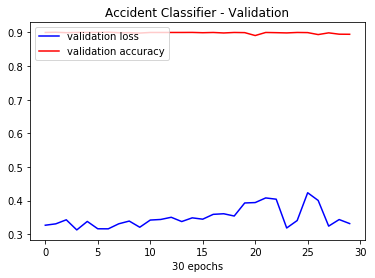

In [21]:
plt.plot(epochs, val_loss, '-b', label='validation loss')
plt.plot(epochs, val_acc, '-r', label='validation accuracy')

plt.xlabel("30 epochs")
plt.legend(loc='upper left')
plt.title("Accident Classifier - Validation")

plt.savefig("figures/accident_classifier_nonweighted_e30_val" + ".png")  
plt.show()

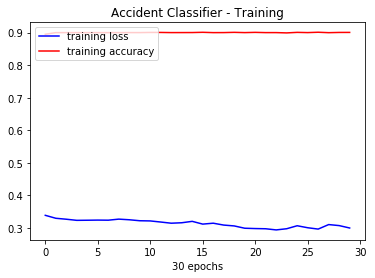

In [22]:
plt.plot(epochs, training_loss, '-b', label='training loss')
plt.plot(epochs, training_acc, '-r', label='training accuracy')

plt.xlabel("30 epochs")
plt.legend(loc='upper left')
plt.title("Accident Classifier - Training")

plt.savefig("figures/accident_classifier_nonweighted_e30_train" + ".png")  
plt.show()

In [14]:
def model_inference(video_path): 
    
    file_idx = video_path.split("/")[-1]
    
    frame_names = []
    for frame in os.listdir(video_path):
        frame_names.append(frame)
    frame_names = sorted(frame_names)

    frames = []
    for frame in frame_names:
        img = load_img(video_path + "/" + frame, target_size = (256, 256))
        img = img_to_array(img)
        img =  img / 255.
        frames.append(img)
    frames = np.array(frames)

    lrcn = LRCN(seq_length = 25, saved_model = None)
    #lrcn.model.load_weights("saved_models/accident_classifier_nonweighted/accident_classifier_nonweighted.004-0.323.hdf5")
    
    lrcn = load_model("saved_models/accident_classifier_nonweighted/prev_model/dashcam_classifier_013-0.302.hdf5")
    
    predictions = []
    for i in range(0, 100, 20):
        input_sequence = frames[i : i + 20]
        input_sequence = np.array([input_sequence])
        pred = lrcn.predict(input_sequence)
        pred = np.reshape(pred, (20, 1))      
        for i in pred:
            predictions.append(i[0])

    plt.plot(range(100), predictions, '-b', label='validation activations')
    plt.ylabel("Final activations")
    plt.xlabel("Frames - " + file_idx)
    plt.title("Accident Classifier - Inference")
    plt.show()

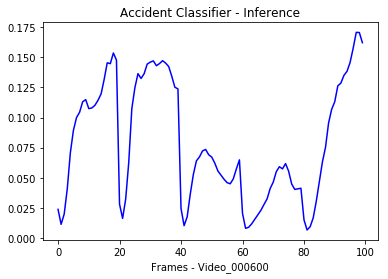

In [20]:
model_inference("dashcam/frames/testing/positive/000600")

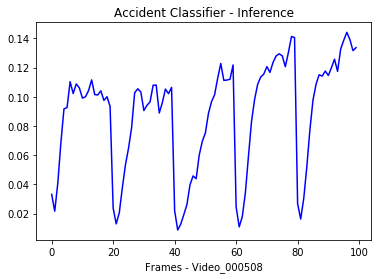

In [15]:
model_inference("dashcam/frames/testing/positive/000508")

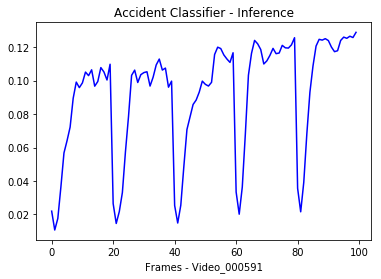

In [32]:
model_inference("dashcam/frames/testing/positive/000591")

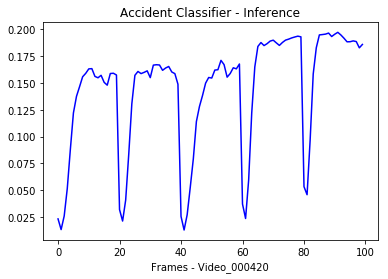

In [30]:
model_inference("dashcam/frames/training/positive/000420")

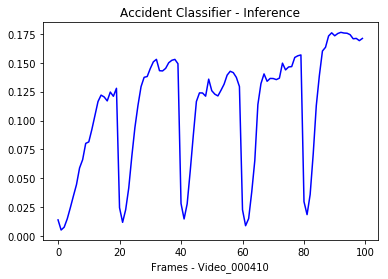

In [33]:
model_inference("dashcam/frames/training/positive/000410")

In [52]:
def model_inference(video_path): 
    
    file_idx = video_path.split("/")[-1]
    
    frame_names = []
    for frame in os.listdir(video_path):
        frame_names.append(frame)
    frame_names = sorted(frame_names)

    frames = []
    for frame in frame_names:
        img = load_img(video_path + "/" + frame, target_size = (256, 256))
        img = img_to_array(img)
        img =  img / 255.
        frames.append(img)
    frames = np.array(frames)

    lrcn = LRCN(seq_length = 25, saved_model = None)
    lrcn = load_model("saved_models/accident_classifier_nonweighted/prev_model/dashcam_classifier_013-0.302.hdf5")
    
    predictions = []
    for i in range(0, 100, 20):
        input_sequence = frames[i : i + 20]
        input_sequence = np.array([input_sequence])
        pred = lrcn.predict(input_sequence)
        pred = np.reshape(pred, (20, 1))      
        for j in pred:
            predictions.append(j[0])
    plt.figure(figsize = (20,10))      
    for i in range(100):
        plt.subplot(1,2,1)
        plt.imshow(frames[i])
        plt.subplot(1,2,2)
        plt.plot(predictions[:i], '-b', label='validation activations')
        plt.ylim([0, 0.2])
        plt.xlim([0, 100])
        plt.ylabel("Final activations")
        plt.xlabel("Frames - " + file_idx)
        plt.title("Accident Classifier - Inference")
        plt.savefig("figures/inference_video/accident_classifier_nonweighted/000410/000" + str(file_idx) +  "_" + str(i) + ".png")

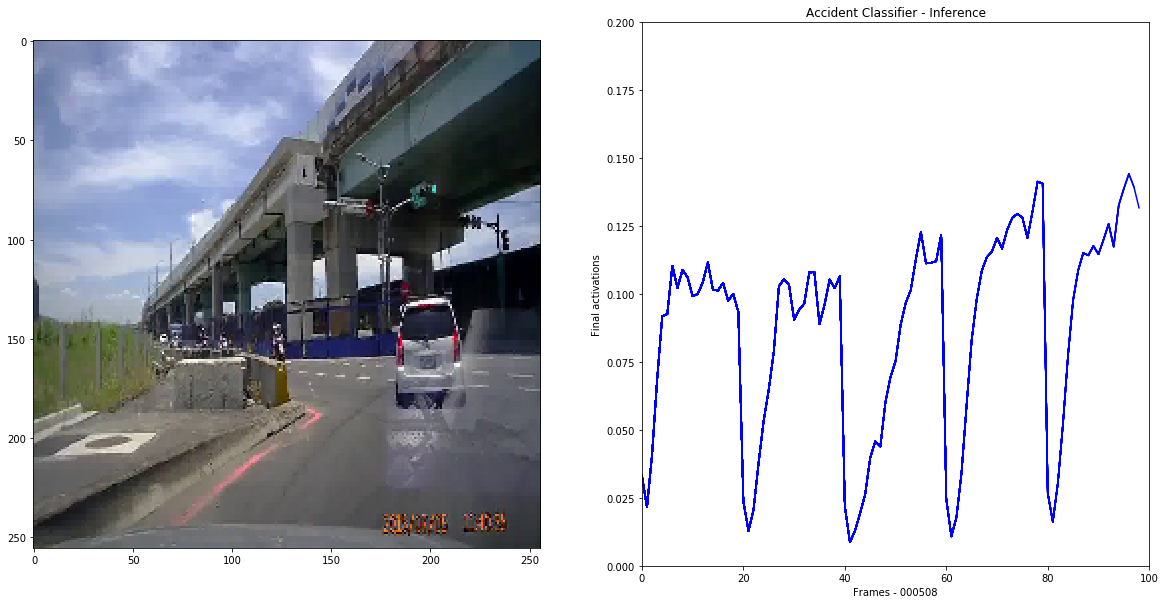

In [53]:
model_inference("dashcam/frames/testing/positive/000508")

In [58]:
inferences = []

for img in os.listdir("figures/inference_video/accident_classifier_nonweighted"):
    inferences.append(img)
inferences = sorted(inferences)

plots = []
for inference in inferences:
    if(inference != ".ipynb_checkpoints"):
        plot = cv2.imread("figures/inference_video/accident_classifier_nonweighted/" + inference)
        plots.append(plot)
plots = np.asarray(plots)

writer = skvideo.io.FFmpegWriter("output.mp4")
for i in range(10):
        writer.writeFrame(plots[i, :, :, :])
writer.close()

In [56]:
import cv2
import os

width = 1440
height = 720
FPS = 30

video = cv2.VideoWriter('figures/inference_video/accident_classifier_nonweighted/000508.avi', cv2.VideoWriter_fourcc(*'DIVX'), float(FPS), (width, height))

inf = os.listdir("figures/inference_video/accident_classifier_nonweighted/000410")
inf.sort()

# out = cv2.VideoWriter(pathOut,, fps, size)
for inference in inf:
    if(inference != ".ipynb_checkpoints"):
        print(inference)
        plot = cv2.imread("figures/inference_video/accident_classifier_nonweighted/000410/" + inference)
        print(plot.shape)
        video.write(plot)
video.release()

000000508_0.png
(720, 1440, 3)
000000508_1.png
(720, 1440, 3)
000000508_10.png
(720, 1440, 3)
000000508_11.png
(720, 1440, 3)
000000508_12.png
(720, 1440, 3)
000000508_13.png
(720, 1440, 3)
000000508_14.png
(720, 1440, 3)
000000508_15.png
(720, 1440, 3)
000000508_16.png
(720, 1440, 3)
000000508_17.png
(720, 1440, 3)
000000508_18.png
(720, 1440, 3)
000000508_19.png
(720, 1440, 3)
000000508_2.png
(720, 1440, 3)
000000508_20.png
(720, 1440, 3)
000000508_21.png
(720, 1440, 3)
000000508_22.png
(720, 1440, 3)
000000508_23.png
(720, 1440, 3)
000000508_24.png
(720, 1440, 3)
000000508_25.png
(720, 1440, 3)
000000508_26.png
(720, 1440, 3)
000000508_27.png
(720, 1440, 3)
000000508_28.png
(720, 1440, 3)
000000508_29.png
(720, 1440, 3)
000000508_3.png
(720, 1440, 3)
000000508_30.png
(720, 1440, 3)
000000508_31.png
(720, 1440, 3)
000000508_32.png
(720, 1440, 3)
000000508_33.png
(720, 1440, 3)
000000508_34.png
(720, 1440, 3)
000000508_35.png
(720, 1440, 3)
000000508_36.png
(720, 1440, 3)
000000508_37

In [44]:
video = io.open('figures/inference_video/accident_classifier_nonweighted/000410.avi', 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii')))

In [55]:
%%HTML
<video width="320" height="240" controls>
  <source src="figures/inference_video/accident_classifier_nonweighted/000610.mp4" type="video/mp4">
</video>

In [54]:
HTML("""
<div align="middle">
<video width="80%" controls>
      <source src="figures/inference_video/accident_classifier_nonweighted/000610.mp4" type="video/mp4">
</video></div>""")